## Programming Exercise 3: Multi-class Classification and Neural Networks

In [102]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io # 用于导入OCTAVE格式的文件
import scipy.misc # 用于将矩阵展现层图像
import warnings
import matplotlib.cm as cm # 用于展现有颜色的图
import random # 用于随机挑选图片来展现
from scipy.special import expit # 向量化sigmoid函数
warnings.filterwarnings("ignore") # 忽略弃用警告

### 1 Multi-class Classification

#### 1.1 Dataset

In [105]:
datafile = 'E:\BaiduYunDownload\Andrew NG\machinelearning.ai\课程\作业\答案\ex3\ex3data1.mat'
mat = scipy.io.loadmat( datafile )
X, y = mat['X'], mat['y']
X = np.insert(X,0,1,axis=1)
print("'y' shape: %s. Unique elements in y: %s"%(mat['y'].shape,np.unique(mat['y'])))
print("'X' shape: %s. X[0] shape: %s"%(X.shape,X[0].shape))
#X 有5000张图，每一张都是一列，400像素（20×20）
#y 是对每一张图片的分类. 1-10, 其中10是手写数字的0

'y' shape: (5000, 1). Unique elements in y: [ 1  2  3  4  5  6  7  8  9 10]
'X' shape: (5000, 401). X[0] shape: (401,)


#### 1.2 Visualizing the data

In [106]:
def getDatumImg(row):
    """
    传递形状为1x400的单个np数组的函数，
    从中创建一个图像对象，然后返回它
    """
    width, height = 20, 20
    square = row[1:].reshape(width,height)
    return square.T
    
def displayData(indices_to_display = None):
    """
    从X中选取100个随机行的函数，从每个行创建一个20x20的图像，
    然后将它们拼接成10x10网格图像，并显示出来。
    """
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indices_to_display:
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx])
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage( big_picture )
    plt.imshow(img,cmap = cm.Greys_r)

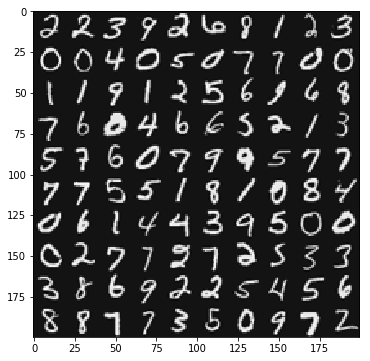

In [107]:
displayData()

#### 1.3 Vectorizing Logistic Regression

In [108]:
def h(mytheta,myX): 
    return expit(np.dot(myX,mytheta))

def computeCost(mytheta,myX,myy,mylambda = 0.):
    m = myX.shape[0] #5000
    myh = h(mytheta,myX) #shape: (5000,1)
    term1 = np.log( myh ).dot( -myy.T ) #shape: (5000,5000)
    term2 = np.log( 1.0 - myh ).dot( 1 - myy.T ) #shape: (5000,5000)
    left_hand = (term1 - term2) / m #shape: (5000,5000)
    right_hand = mytheta.T.dot( mytheta ) * mylambda / (2*m) #shape: (1,1)
    return left_hand + right_hand #shape: (5000,5000)

#### 1.4 One-vs-all Classification

In [109]:
# OCTAVE'fmincg'的替代品我们将使用一些scipy.optimize函数，“fmin_cg”
# 这于大量参数更有效，在之前的作业中，没有必要计算成本梯度，因为the scipy.optimize函数通过某种插值做了。但是，fmin_cg需要递交的渐变，将在这里实现

def costGradient(mytheta,myX,myy,mylambda = 0.):
    m = myX.shape[0]
    # 这里转置y因为后面可以点乘
    beta = h(mytheta,myX)-myy.T #shape: (5000,5000)

    # 在正则化theta中跳过第一个数
    regterm = mytheta[1:]*(mylambda/m) #shape: (400,1)

    grad = (1./m)*np.dot(myX.T,beta) #shape: (401, 5000)
    grad[1:] = grad[1:] + regterm
    return grad #shape: (401, 5000)

In [110]:
from scipy import optimize

def optimizeTheta(mytheta,myX,myy,mylambda=0.):
    result = optimize.fmin_cg(computeCost, fprime=costGradient, x0=mytheta, \
                              args=(myX, myy, mylambda), maxiter=50, disp=False,\
                              full_output=True)
    return result[0], result[1]

In [111]:
#Note: I spent a LONG time trying to optimize everything. Initially training 10 classes
#took about 5 minutes. Now I've got it down to taking ~5 seconds total!
def buildTheta():
    """
    确定每个类的优化theta的函数
    并返回每行对应的Theta函数
    对于一个级别的学习逻辑回归参数
    """
    mylambda = 0.
    initial_theta = np.zeros((X.shape[1],1)).reshape(-1)
    Theta = np.zeros((10,X.shape[1]))
    for i in range(10):
        iclass = i if i else 10 #class "10" corresponds to handwritten zero
        print("Optimizing for handwritten number %d..."%i)
        logic_Y = np.array([1 if x == iclass else 0 for x in y])#.reshape((X.shape[0],1))
        itheta, imincost = optimizeTheta(initial_theta,X,logic_Y,mylambda)
        Theta[i,:] = itheta
    print("OJ8K!")
    return Theta

In [113]:
Theta = buildTheta()

Optimizing for handwritten number 0...
Optimizing for handwritten number 1...
Optimizing for handwritten number 2...
Optimizing for handwritten number 3...
Optimizing for handwritten number 4...
Optimizing for handwritten number 5...
Optimizing for handwritten number 6...
Optimizing for handwritten number 7...
Optimizing for handwritten number 8...
Optimizing for handwritten number 9...
OJ8K!


In [114]:
def predictOneVsAll(myTheta,myrow):
    """
    计算单个图像假设的函数（X中的行）
    并返回与手写图像对应的预测整数
    """
    classes = [10] + [x for x in range(1,10)]
    hypots  = [0]*len(classes)
    # 计算每种可能结果的假设
    
    # 选择最大假设来查找结果
    for i in range(len(classes)):
        hypots[i] = h(myTheta[i],myrow)
    return classes[np.argmax(np.array(hypots))]    

In [115]:
# "You should see that the training set accuracy is about 94.9%"
n_correct, n_total = 0., 0.
incorrect_indices = []
for irow in range(X.shape[0]):
    n_total += 1
    if predictOneVsAll(Theta,X[irow]) == y[irow]: 
        n_correct += 1
    else: incorrect_indices.append(irow)
print("Training set accuracy: %0.1f%%"%(100*(n_correct/n_total)))

Training set accuracy: 95.3%


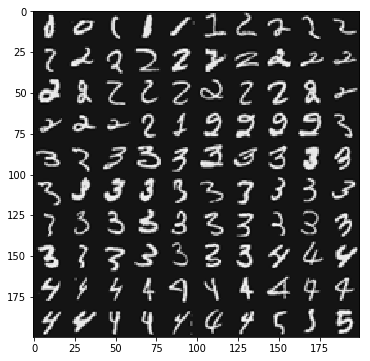

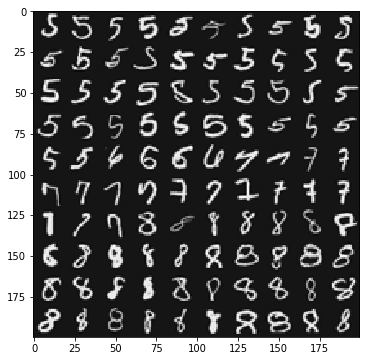

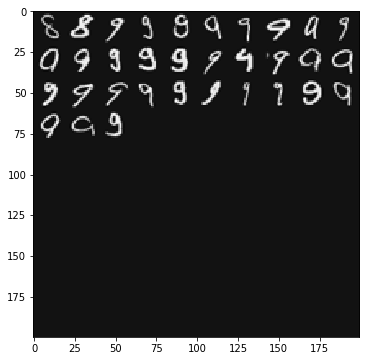

In [116]:
# 看看是哪里错了:
displayData(incorrect_indices[:100])
displayData(incorrect_indices[100:200])
displayData(incorrect_indices[200:300])

### 2 Neural Networks

#### 2.1 Model representation

In [117]:
# 获得了一组网络参数（Θ（1），Θ（2））
# 我们已经训练好的
# 这些存储在ex3weights.mat中
datafile = 'E:\BaiduYunDownload\Andrew NG\machinelearning.ai\课程\作业\答案\ex3\ex3weights.mat'
mat = scipy.io.loadmat( datafile )
Theta1, Theta2 = mat['Theta1'], mat['Theta2']
print("Theta1 has shape:",Theta1.shape)
print ("Theta2 has shape:",Theta2.shape)

Theta1 has shape: (25, 401)
Theta2 has shape: (10, 26)


#### 2.2 Feedforward Propagation

In [118]:
def propagateForward(row,Thetas):
    """
    给出Thetas列表的函数，进行前馈传播
    假设函数已经包括输入层中的偏置单元，以及这些需要在每层之间添加偏置单元
    """
    features = row
    for i in range(len(Thetas)):
        Theta = Thetas[i]
        z = Theta.dot(features)
        a = expit(z)
        if i == len(Thetas)-1:
            return a
        a = np.insert(a,0,1) # 增加偏差单元
        features = a

def predictNN(row,Thetas):
    """
    占用一行特征的函数，通过它传播它们
    NN，并返回手写的预测整数
    """
    classes = [x for x in range(1,10)] + [10]
    output = propagateForward(row,Thetas)
    return classes[np.argmax(np.array(output))]

In [119]:
myThetas = [ Theta1, Theta2 ]
n_correct, n_total = 0., 0.
incorrect_indices = []
# 遍历X中的所有行（所有手写图像）

# 预测写入的数字并且检查它是否正确

# 计算效率
for irow in range(X.shape[0]):
    n_total += 1
    if predictNN(X[irow],myThetas) == int(y[irow]): 
        n_correct += 1
    else: incorrect_indices.append(irow)
print("Training set accuracy: %0.1f%%"%(100*(n_correct/n_total)))

Training set accuracy: 97.5%


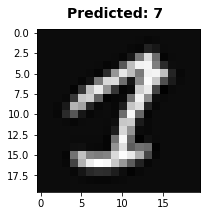

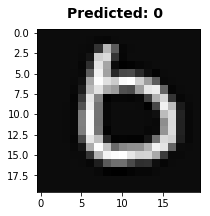

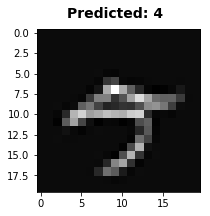

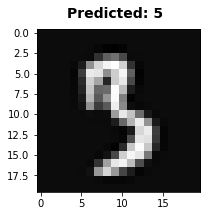

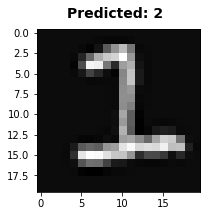

In [120]:
# 让我们看看辣鸡计算机是哪里认错了
for x in range(5):
    i = random.choice(incorrect_indices)
    fig = plt.figure(figsize=(3,3))
    img = scipy.misc.toimage( getDatumImg(X[i]) )
    plt.imshow(img,cmap = cm.Greys_r)
    predicted_val = predictNN(X[i],myThetas)
    predicted_val = 0 if predicted_val == 10 else predicted_val
    fig.suptitle('Predicted: %d'%predicted_val, fontsize=14, fontweight='bold')